Need to install nptdms. Command: conda install -c conda-forge nptdms

In [183]:
import pandas as pd
from nptdms import TdmsFile
import os
from datetime import datetime
import numpy as np

In [184]:
import matplotlib.pyplot as plt
import plotly.express as px

Data for temperature and humidity. This comes from Pai's DSC google drive. According to Pai, he only backed up temperature and humidity data until 6 months ago. So we still need to figure out how to extract data from DSC. <br>Link to Pai's DSC folder: https://drive.google.com/drive/folders/0BxuhdUf7uaUYcTVhVzhJeDZEMG8?usp=sharing
<br> Below I use 2017-08-28.txt in /MFP3D/MFP3D_Temperature to test how to read .txt file

In [5]:
folder = './MFP3D_Hum'

In [7]:
files = os.listdir(folder)

In [20]:
files

['2016-03-19.txt',
 '2016-04-18.txt',
 '2016-05-18.txt',
 '2016-06-16.txt',
 '2017-08-28.txt',
 '2019-06-12.txt']

In [19]:
time_test = os.path.getmtime('/'.join([folder, files[0]]))

datetime.utcfromtimestamp(time_test).strftime('%Y-%m-%d %H:%M:%S')

'2020-03-01 04:52:00'

In [15]:
os.path.getctime('/'.join([folder, files[0]]))

1583038304.568966

In [7]:
path = folder + '/2017-08-28.txt'

In [10]:
data = pd.read_csv(path, sep="\t", header = None)

In [25]:
data[['date','time']] = data[0].str.split(expand=True)
data.drop(0, axis=1, inplace=True)

In [27]:
data.rename(columns = {1: 'time_labview',
             2: 'Temp'}, inplace = True)

reformatting date and time columns. More processing steps needed

Data for device writing log files containing 2T conductance or current 

.Dat file

.tdms file

Create a simple pipeline

In [84]:
def read_tdms(path, file):
    file = '/'.join([path,file])
    tdms_file_test = TdmsFile(file)
    
    time = tdms_file_test.object('contact data', 'time')
    time_data = time.data
    
    G_2t = tdms_file_test.object('conductance data', '2tG')
    G_2t_data = G_2t.data
    
    G_4t = tdms_file_test.object('conductance data', '4tG')
    G_4t_data = G_4t.data
    
    return time_data, G_2t_data, G_4t_data

In [476]:
# Maybe I can do some more improvement about this writing process_extractor
class Pulsed_writing_process_Extractor:
    
    def __init__(self, time_data, G2t_data):
        
        self.time_data = time_data
        self.G2t_data = G2t_data
        
        self.data_length = len(time_data)
        self.time_end = 0
        self.G2t_end = 0
        self.end_found = False
        
        self.second_mini = 100
        self.second_mini_time = -1
        self.second_mini_found = False
        
        self.peak = 0
        self.peak_time = 0
        self.peak_found = False
        
        self.first_mini = 100
        self.first_mini_time = -1
        self.first_mini_found = False
        
        self.time_start = 0
        self.G2t_start = 0
        self.start_found = False
        
        self.threshould = 1*10**(-9)
        
        
    def get_endtime(self, index):
        
        G2t = self.G2t_data[index]
        time = self.time_data[index]
        
        if (G2t > self.G2t_end)|((np.abs(G2t - self.G2t_end)>2 * 10 **(-10))&(np.abs(G2t - self.G2t_end)<self.threshould))|(G2t < 10 ** (-8)):
            self.time_end = time
            self.G2t_end = G2t
        else:
        
            if (self.time_end - time) >= 3:
                self.end_found = True
                #self.time_end = time
        
        return self.time_end, index, self.G2t_end

    def get_second_min(self, index):
        
        G2t = self.G2t_data[index]
        time = self.time_data[index]
        
        if (G2t < self.second_mini)|(np.abs(G2t - self.second_mini) < self.threshould):
            self.second_mini = G2t
            self.second_mini_time = time
        else:
            if (self.second_mini_time - time) >= 3:
                self.second_mini_found = True
                
        return self.second_mini_time, index, self.second_mini

    def get_first_min(self, index):
        
        G2t = self.G2t_data[index]
        time = self.time_data[index]
        
        if (G2t < self.first_mini)|(np.abs(G2t - self.first_mini) < self.threshould):
            self.first_mini = G2t
            self.first_mini_time = time
        else:
            if (self.first_mini_time - time) >= 3:
                self.first_mini_found = True
        
        return self.first_mini_time, index, self.first_mini

    def get_middle_peak(self, index):
        
        G2t = self.G2t_data[index]
        time = self.time_data[index]
        
        if (G2t > self.peak)|(np.abs(G2t - self.peak) < self.threshould):
            self.peak = G2t
            self.peak_time = time
        else:
            if (self.peak_time - time) >= 2:
                self.peak_found = True
                
        return self.peak_time, index, self.peak

    def get_start_time(self, index):
        
        G2t = self.G2t_data[index]
        time = self.time_data[index]
        
        if (G2t - self.G2t_start) > self.threshould:
            self.G2t_start = G2t
            self.time_start = time
        else:
            if (self.time_start - time) >= 3:
                self.start_found = True
                
        return self.time_start, index, self.G2t_start
    
    def get_data(self):
        
        i = len(self.G2t_data) - 1 
        
        while i >= 0:
            
            if self.end_found == False:
                self.get_endtime(i)
                
            elif self.second_mini_found == False:
                _, index, _ = self.get_second_min(i)
                #if self.second_mini_found == True:
                #    i = index
                
            elif self.peak_found == False:
                self.get_middle_peak(i)
                
            elif self.first_mini_found == False:
                self.get_first_min(i)
                
            elif self.start_found == False:
                self.get_start_time(i)
            
            else:
                break
            
            i -= 1
        
        return self.time_start, self.time_end, self.start_found

In [ ]:
def writing_process_generation(writing_extractor):
    
    index = 0
    time_data_slice = []
    G2t_data_slice = []

    for time in writing_extactor.time_data:

        if (time > writing_extractor.start) & (time < writing_extractor.end):
            time_data_slice.append(time)
            G2t_data_slice.append(writing_extractor.G2t[index])

        index += 1
        
    return time_data_slice, G2t_data_slice

In [ ]:
def whole_process(folder, by = 'all'):
    if by == 'all':
        files = os.listdir(folder)
        if 'tdms' in files[0]:
            files = [file for file in files if 'index' not in file]
            
            for file in files:
                
                time_data, G_2t_data, G_4t_data = read_tdms(folder, file)
                writing_extractor = Pulsed_writing_process_Extractor(time_data, G_2t_data)
                start, end, found = writing_extractor.get_data()
                
                if found == True:
                    
                    time_data_slice, G2t_data_slice = writing_process_generation(writing_extractor)
                    # Process to get the date and extract humidity and temperature from database
                    
                    break

In [480]:
folder = './tdms/20160429'

In [481]:
files = os.listdir(folder)

In [484]:
files = [file for file in files if 'index' not in file]

In [485]:
files

['SA02821.006515.tdms',
 'SA02821.006516.tdms',
 'SA02821.006517.tdms',
 'SA02821.006518.tdms',
 'SA02821.006519.tdms',
 'SA02821.006520.tdms',
 'SA02821.006521.tdms',
 'SA02821.006522.tdms',
 'SA02821.006523.tdms',
 'SA02821.006524.tdms',
 'SA02821.006525.tdms',
 'SA02821.006526.tdms']

In [467]:
file_index = -2

In [468]:
G2t_data_writing= G2t_data_lst_1[file_index]
time_data_writing= time_data_lst_1[file_index]

In [469]:
writing_extractor = Pulsed_writing_process_Extractor(time_data_writing, G2t_data_writing)

In [470]:
start, end, found = writing_extractor.get_data()

In [471]:
found

True

In [472]:
writing_extractor.second_mini_time, writing_extractor.first_mini_time, writing_extractor.peak_time

(414.60846, 349.40494, 357.8058)

In [473]:
end

581.71515

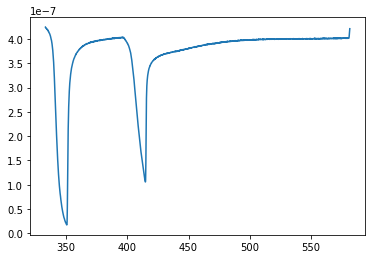

In [474]:
index = 0
time_data_slice = []
tip_V_slice = []
G2t_data_slice = []

for time in time_data_lst_1[file_index]:
    
    if (time > start) & (time < end):
        time_data_slice.append(time)
        #tip_V_slice.append(tip_V_lst[file_index][index])
        G2t_data_slice.append(G2t_data_lst_1[file_index][index])
        
    index += 1
    
plt.plot(time_data_slice, G2t_data_slice)

In [85]:
folder_tdms = './tdms/20160531/20160531'
files_tdms = os.listdir(folder_tdms)
files_tdms = [file for file in files_tdms if not ('index' in file)]

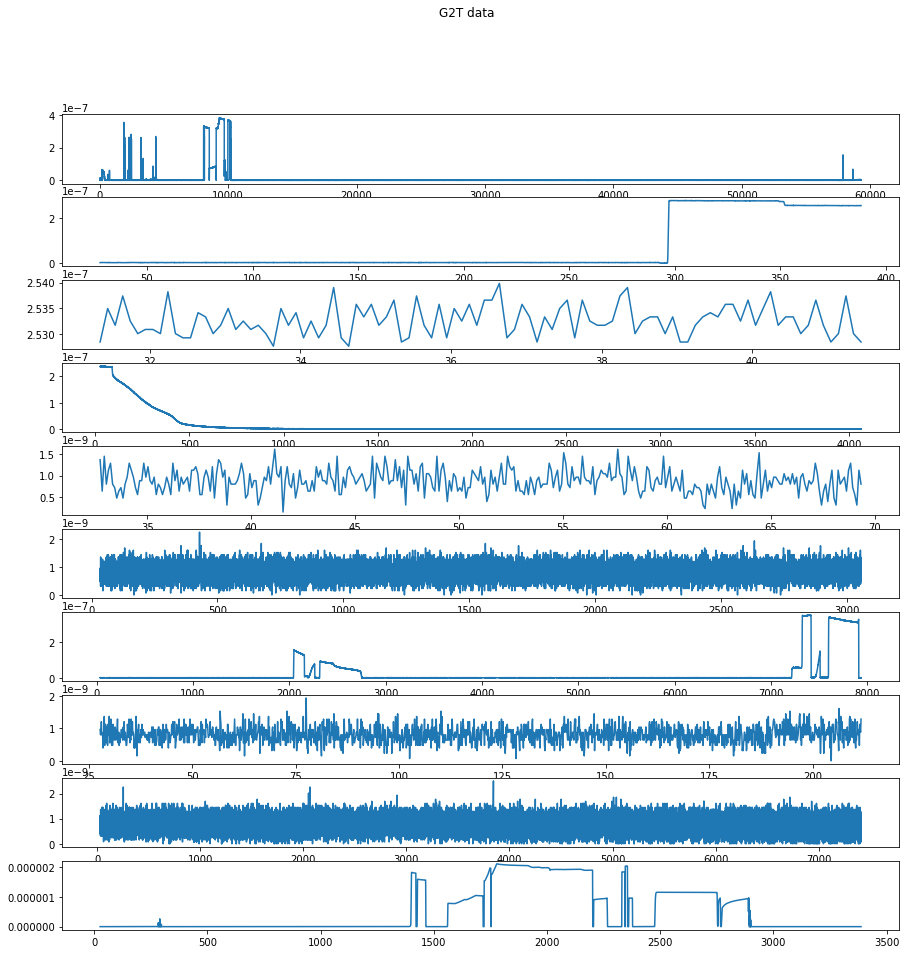

In [88]:
fig, axs = plt.subplots(len(files_tdms))
fig.suptitle('G2T data')
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(len(files_tdms)):
    axs[i].plot(time_data_lst[i], G2t_data_lst[i])

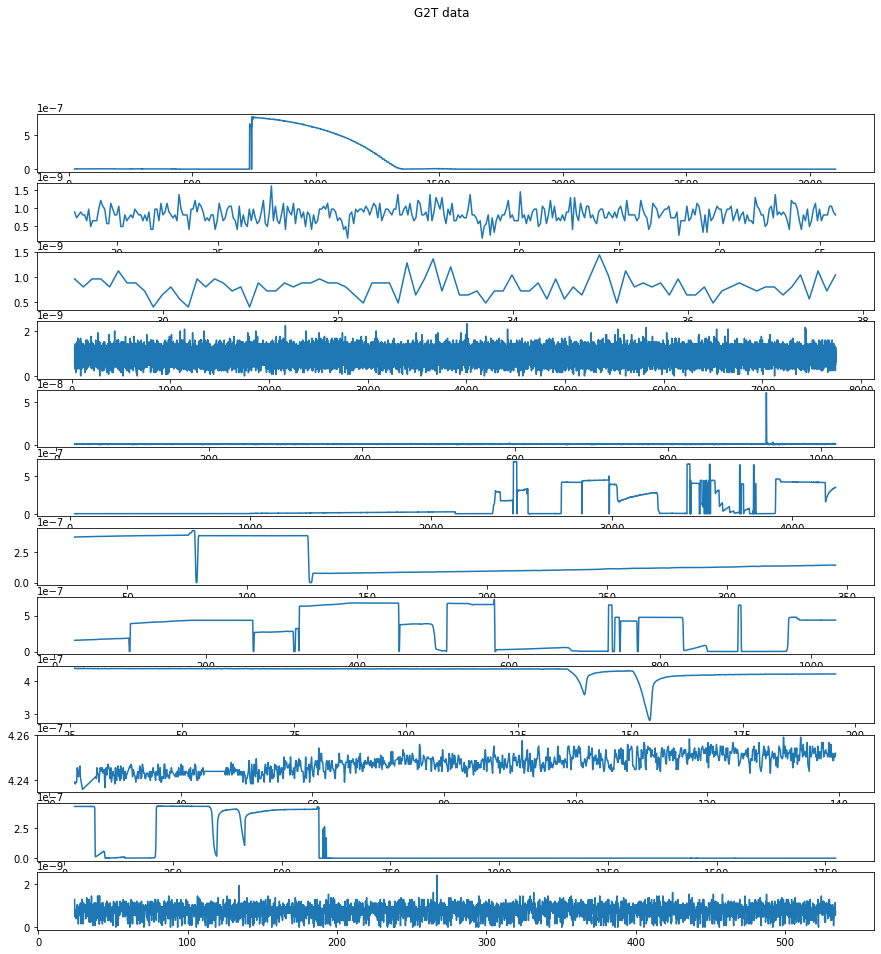

In [95]:
fig, axs = plt.subplots(len(files_tdms))
fig.suptitle('G2T data')
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(len(files_tdms)):
    axs[i].plot(time_data_lst_1[i], G2t_data_lst_1[i])